# Question 1

Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?

#### Import Libraries

Files flatiron_stats.py and flatiron_sql.py contain functions related to sampling and sample comparison as well as some basic sql queries.

In [1]:
#import libraries
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols

#For tukey test
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

#For KS Test
from scipy import stats

#For Sampling, Welch's T-Test, Cohen's d - flatiron_stats.py. I have updated with my own functions.
from flatiron_stats import p_value_welch_ttest, welch_t, cohens_d, get_sampling_means

#For SQL Helpter functions
from flatiron_sql import view_table, get_table, get_table_names

#For Power Analysis
from statsmodels.stats.power import TTestIndPower, TTestPower

#significance level
alpha = 0.05

Establish connection to Northwind Database

In [2]:
#connect to the Northwind database
conn = sqlite3.connect("Northwind_small.sqlite")

### Summary Stats for Quantity by Discount Level
Run an initial query to look at a summary of the data of interest. I want to see summary statistics for quantity per order grouped by discount amount.

In [3]:
query = """SELECT Discount, 
                  ROUND(avg(Quantity),2) AS AvgQuantity,
                  min(Quantity) AS MinQuantity,
                  max(Quantity) AS MaxQuantity,
                  count(*) AS TotalOrders
           FROM OrderDetail
           GROUP BY Discount
           """
pd.read_sql(query,conn)

,Discount,AvgQuantity,MinQuantity,MaxQuantity,TotalOrders
0,0.00,21.72,1,130,1317
1,0.01,2.00,2,2,1
2,0.02,2.00,1,3,2
3,0.03,1.67,1,2,3
4,0.04,1.00,1,1,1
5,0.05,28.01,1,120,185
6,0.06,2.00,2,2,1
7,0.10,25.24,2,130,173
8,0.15,28.38,2,100,157
9,0.20,27.02,2,100,161


## Hypothesis

**Ho:** There is no difference in the mean product quantity ordered between customers who received a discount and those who did not receive a discount.

**Ha:** The mean product quantity ordered for those who received a discount will be greater than the mean product quantity ordered by customers who did not receive a discount. i.e. mean quantity for discounted > 21.72

Average Quantity does seem higher for disounted (with the exception of the 0.01,0.02,0.03,0.04,0.06 discount levels which just don't have much data at all)

## Visualize the Data

In [6]:
#Query OrderDetail table - it contains all of the data needed for this question
df = get_table('OrderDetail',conn)

Text(0, 0.5, 'Quantity Ordered')

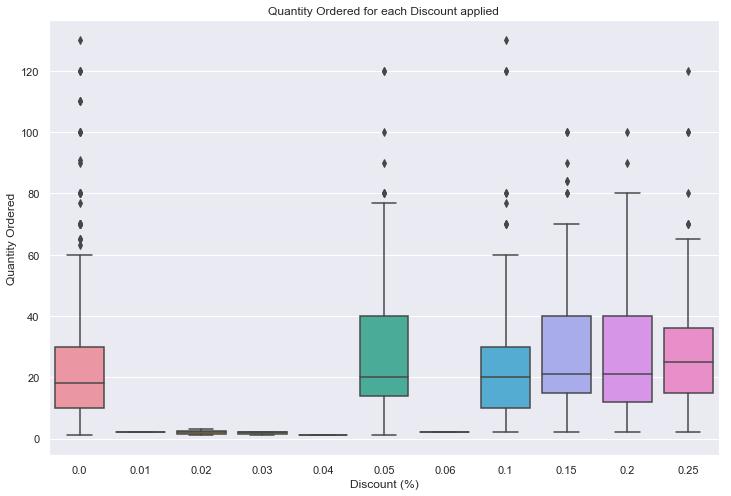

In [8]:
sns.set(rc={'figure.figsize':(12,8)})
sns.boxplot(x='Discount',y='Quantity',data=df)
plt.title('Quantity Ordered for each Discount applied')
plt.xlabel('Discount (%)');
plt.ylabel('Quantity Ordered')

Dropping discount levels that don't have enough data.

Text(0, 0.5, 'Quantity Ordered')

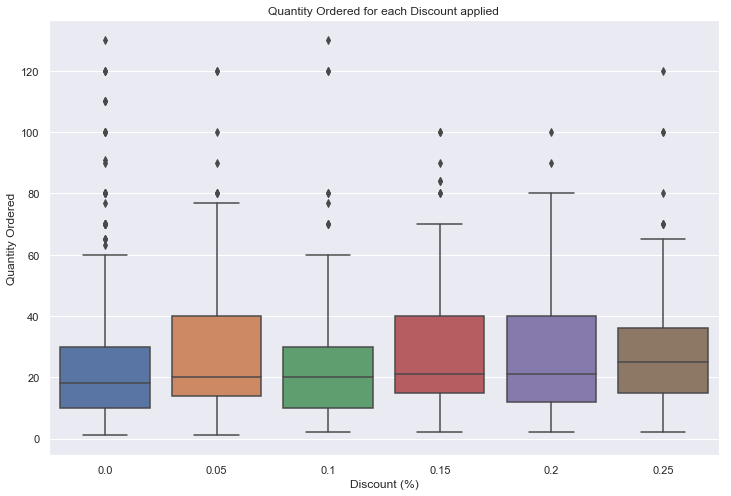

In [9]:
#Drop some data for the visualization
data_to_drop = [0.01, 0.02, 0.03, 0.04, 0.06]
df = df[~df.Discount.isin(data_to_drop)]

sns.set(rc={'figure.figsize':(12,8)})
sns.boxplot(x='Discount',y='Quantity',data=df)
plt.title('Quantity Ordered for each Discount applied')
plt.xlabel('Discount (%)');
plt.ylabel('Quantity Ordered')

## ANOVA Test

In [10]:
#ANOVA TEST
formula = "Quantity ~ C(Discount)"
lm = ols(formula, df).fit()
table = sm.stats.anova_lm(lm, typ=2)
table['reject_null'] = table['PR(>F)'] < alpha
print(table)

                    sum_sq      df         F        PR(>F)  reject_null
C(Discount)   17348.854662     5.0  9.798709  2.840681e-09         True
Residual     758138.565924  2141.0       NaN           NaN        False


Discount does have a statistically significant effect on Order Quantity. **Null Hypothesis can be rejected.**

## Tukey Test

**Investigate individual discount levels compared to full price**

In [11]:
#TUKEY TEST
mc = MultiComparison(df['Quantity'], df['Discount'])
result = mc.tukeyhsd()
print("Groups are Discount amounts, summary stats are Quantity\n")
#Convert result to dataframe for prettiness and to only show the comparisons that include no-discount
result_df = pd.DataFrame(data=result._results_table.data[1:], columns=result._results_table.data[0])
print("Multiple Comparison of Means - Tukey HSD,FWER=0.05")
result_df[result_df.group1==0.00]

Groups are Discount amounts, summary stats are Quantity

Multiple Comparison of Means - Tukey HSD,FWER=0.05


,group1,group2,meandiff,lower,upper,reject
0,0.0,0.05,6.2955,2.0814,10.5097,True
1,0.0,0.10,3.5217,-0.8187,7.8622,False
2,0.0,0.15,6.6669,2.1352,11.1986,True
3,0.0,0.20,5.3096,0.8285,9.7907,True
4,0.0,0.25,6.5250,1.9540,11.0960,True


**Discount levels of 0.05, 0.15, 0.20, 0.25 have a statistically significant impact on Quantity Ordered at a 0.05 significance level.**

## Histogram
Full Price vs Discounted

/Users/dennistrimarchi/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


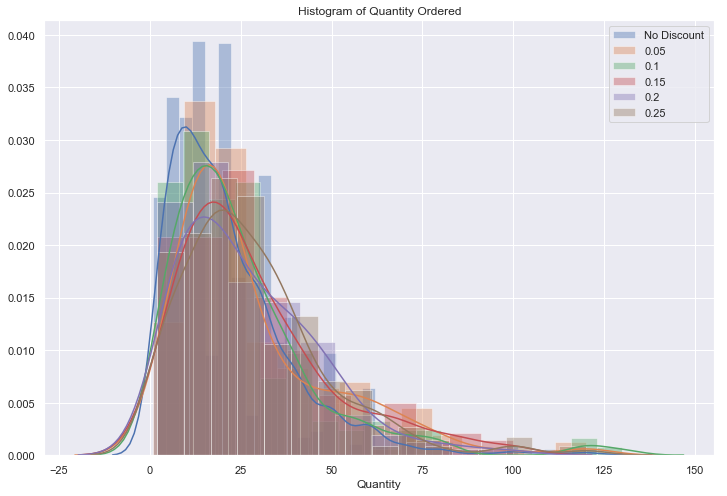

In [46]:
#Get list of all discount levels
discount_levels = list(df.Discount.unique())
discount_levels.sort()

#Set plot size
sns.set(rc={'figure.figsize':(12,8)})

#Plot histogram for each discount level
for discount_level in discount_levels:
    if discount_level == 0.0:
        sns.distplot(df.Quantity[df.Discount==discount_level], label='No Discount')
    else:
        sns.distplot(df.Quantity[df.Discount==discount_level], label=discount_level)
plt.title('Histogram of Quantity Ordered')
plt.legend()

**They look normal-ish, but skewed.**

## Normality

### KS Test
Check if each sample is normal

Full Price:

In [23]:
full_price = df.Quantity[df.Discount==0.0]
mu = full_price.mean()
std = full_price.std()
result = stats.kstest(rvs=full_price,cdf='norm',args=(mu, std))
print("KS TEST FULL PRICE\ntest statistic: {}\npvalue: {}\nIs Normal: {}".format(result.statistic,result.pvalue,result.pvalue>0.05))

KS TEST FULL PRICE
test statistic: 0.1571445192364258
pvalue: 0.0
Is Normal: False


Discounted:

In [24]:
discounted = df.Quantity[df.Discount!=0]
mu = discounted.mean()
std = discounted.std()
result = stats.kstest(rvs=discounted,cdf='norm',args=(mu, std))
print("KS TEST DISCOUNTED\ntest statistic: {}\npvalue: {}\nIs Normal: {}".format(result.statistic,result.pvalue,result.pvalue>0.05))

KS TEST DISCOUNTED
test statistic: 0.1540171703044333
pvalue: 0.0
Is Normal: False


The samples are not normal according to Kolmogorov-Smirnov Test. Will do some sampling in order to create normality according to the Central Limit Theorem.

### Shapiro Test
Checks if each sample is normal

In [25]:
result = stats.shapiro(full_price)
print("SHAPIRO TEST FULL PRICE\ntest statistic: {}\npvalue: {}\nIs Normal: {}".format(result[0],result[1],result[1]>0.05))

SHAPIRO TEST FULL PRICE
test statistic: 0.8434571027755737
pvalue: 3.803856556577728e-34
Is Normal: False


In [26]:
result = stats.shapiro(discounted)
print("SHAPIRO TEST DISCOUNTED\ntest statistic: {}\npvalue: {}\nIs Normal: {}".format(result[0],result[1],result[1]>0.05))

SHAPIRO TEST DISCOUNTED
test statistic: 0.8673426508903503
pvalue: 6.471277454941499e-26
Is Normal: False


The samples are not normal according to Kolmogorov-Smirnov Test. Will do some sampling in order to create normality according to the Central Limit Theorem. 

## Sampling Distributions

/Users/dennistrimarchi/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


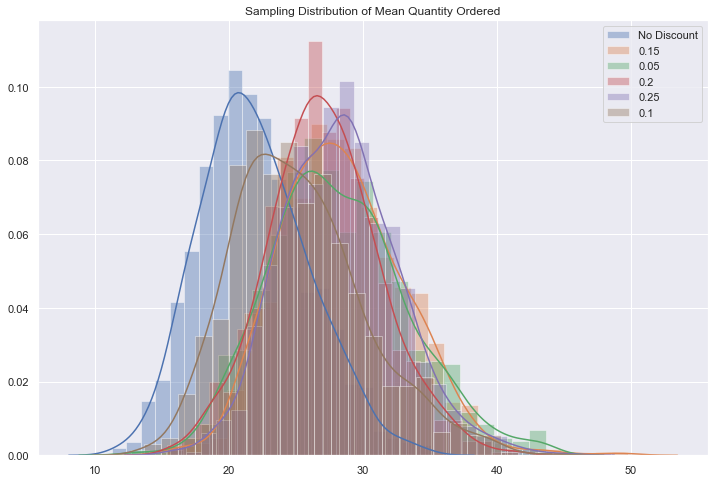

In [34]:
num_samples = 1000
sample_size = 20

#Sampling distribution for all discount levels
sns.set(rc={'figure.figsize':(12,8)});
for discount_level in discount_levels:
    sample = get_sampling_means(df.Quantity[df.Discount==discount_level],num_samples,sample_size)
    label = discount_level
    if label==0.0:
        label = 'No Discount'
    sns.distplot(sample, label=label)
    
plt.title('Sampling Distribution of Mean Quantity Ordered');
plt.legend();
plt.show()

/Users/dennistrimarchi/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


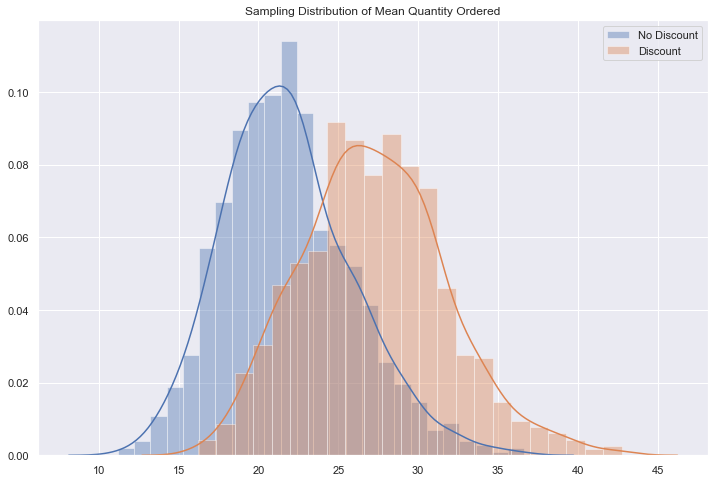

Number of Samples: 1000
Sample Size: 20

Sampling mean of each group.
Full price: 21.816300000000002
Discounted: 27.217
Mean Difference: 5.400699999999997

StdDev of Sample means for each group.
Full price: 4.030382650568058
Discounted: 4.503159002300496


In [35]:
#Sampling distribution for discount vs no discount
full_price_sample_means = get_sampling_means(df.Quantity[df.Discount==0.0],num_samples,sample_size)
discounted_sample_means = get_sampling_means(df.Quantity[df.Discount!=0.0],num_samples,sample_size)

sns.distplot(full_price_sample_means, label='No Discount')
sns.distplot(discounted_sample_means, label='Discount')
plt.title('Sampling Distribution of Mean Quantity Ordered');
plt.legend();
plt.show()

print("Number of Samples: {}\nSample Size: {}\n".format(num_samples,sample_size))
print("Sampling mean of each group.\nFull price: {}\nDiscounted: {}"
      .format(np.mean(full_price_sample_means),np.mean(discounted_sample_means)))
print("Mean Difference: {}\n"
      .format(abs(np.mean(full_price_sample_means)-np.mean(discounted_sample_means))))
print("StdDev of Sample means for each group.\nFull price: {}\nDiscounted: {}"
      .format(np.std(full_price_sample_means),np.std(discounted_sample_means)))

The sampling distribution does a much better job of highlighting the difference in the full price group.

## Welch's T-Test

Raw Data:

In [37]:
#Welch's T-Test on original dataset before sampling
p_orig = p_value_welch_ttest(full_price,discounted, two_sided=False)
t_orig = welch_t(full_price,discounted)
print("Welch's T-Test:\nt: {}  p-val: {}  reject null: {}".format(t_orig,p_orig,p_orig<alpha))

Welch's T-Test:
t: 6.511219067380875  p-val: 5.0256243611102036e-11  reject null: True


Sampled Data:

In [38]:
p = p_value_welch_ttest(full_price_sample_means, discounted_sample_means, two_sided=False)
t = welch_t(full_price_sample_means, discounted_sample_means)

print("Welch's T-Test:\nt: {}  p-val: {}  reject null: {}".format(t,p,p<alpha))

Welch's T-Test:
t: 28.245742326622604  p-val: 0.0  reject null: True


## Effect Size

**Raw Data:**

In [51]:
#Effect size of original dataset before sampling
d_orig = cohens_d(full_price,discounted)
print("Effect Size d: {}".format(d_orig))

Effect Size d: 0.2997133708739262


Check effect size for each discount level against no discount to see which has the largest effect:

In [47]:
for discount_level in discount_levels:
    if discount_level != 0:
        d = cohens_d(full_price,df.Quantity[df.Discount==discount_level])
        print('Effect Size d for discount {}: {}'.format(discount_level,d))

Effect Size d for discount 0.05: 0.3469259331213803
Effect Size d for discount 0.1: 0.19596431111215432
Effect Size d for discount 0.15: 0.3724449105051497
Effect Size d for discount 0.2: 0.3007245635324173
Effect Size d for discount 0.25: 0.36662317783822485


**Sampled Data**

In [49]:
d = cohens_d(full_price_sample_means, discounted_sample_means)
print("Effect Size d: {}".format(d))

Effect Size d: 1.2631879983454244


## Summary / Conclusion

Discount has a statistically significant effect on quantity ordered.
The following table shows the significant discount levels, and their mean difference and effect size with respect to the full price group.

|Discount | Mean Difference | Effect Size | 
|---------|-----------------|-------------|
| 0.05    |    6.29         |     0.347   |
| 0.15    |    6.66         |     0.372   |
| 0.20    |    5.30         |     0.300   |
| 0.25    |    6.52         |     0.367   |

The ranked discount levels by effect size are: 15%, 25%, 5%, 20%. However, in all cases the effect is small to medium (between 0.2 and 0.5).

For discount levels of 1%, 2%, 3%, 4%, 6%, there was not enough data. For discount level of 10%, there was not a statistically significant correlation to quantity ordered.

## Recommendations
Based on these results I would recommend that the company avoid giving 10% discounts as they do not impact order quantity and therefore represent a loss of 10% revenue.

I would also would also ask the company to consider that 15% discounts have a greater effect on quantity ordered than 20%, and 25% discounts.

Depending on inventory, product expiration, etc, there are instances where increasing quantity of product per order is beneficial. In these instances, 15% and 25% discount levels have the greatest effect. 

OTHER STUFF I LOOKED AT BUT WAS NOT RELEVANT TO THE QUESTION

## Statistical Power

Sample size = 20
Effect size = 1.263
Power       = 0.973


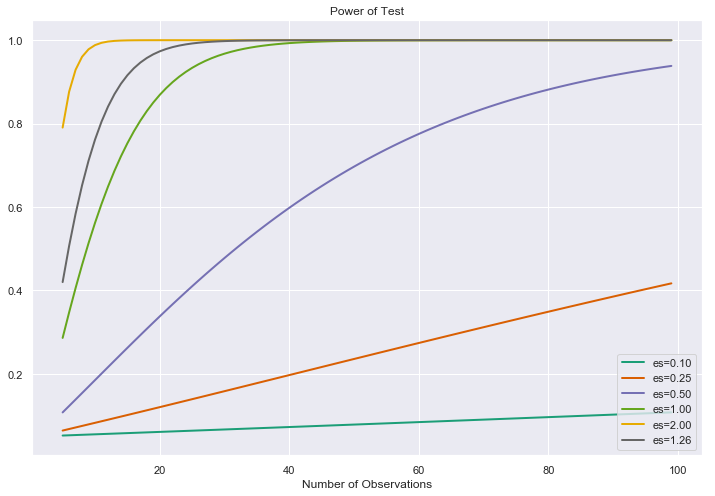

Effect size needed to get power=0.8: 0.9091290568795594


In [54]:
power_analysis = TTestIndPower()
power = power_analysis.solve_power(effect_size=d,nobs1=sample_size,alpha=alpha)
print("Sample size = {}\nEffect size = {}\nPower       = {}".format(sample_size, np.round(d,3), np.round(power,3)))

power_analysis.plot_power(dep_var='nobs',
                         nobs=np.array(range(5,100)),
                         effect_size=[0.1,0.25,0.5,1.0,2.0,d],
                         alpha=alpha)
plt.show()

effect_size_needed = power_analysis.solve_power(power=0.8,nobs1=sample_size,alpha=alpha)
print("Effect size needed to get power=0.8: {}".format(effect_size_needed))